# Connect with Google Drive

Thanks for google to provide google drive and more importantly Colab on which we can use GPU for model training/testing.

We have placed all our data in google drive and easiest way to connect with google drive is to mount it with colab. This is hell of best feature that i ever seen. In this way a google drive simply becomes a simple hard drive and you can perform all operations on it like create new directory, list directories, save models etc. 

In below section we connect with google drive and mount it with our colab notebook.

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Tensor 2.0 Installation

We first need to install tensorflow gpu alpha version so that we can develop our model on latest version. 

please note by defualt tensorflow 1.13 version is installed and you need to first run following code for installation of tensorflow 2.0. 

In [2]:
!pip install tensorflow-gpu==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 50kB/s 
    100% |████████████████████████████████| 419kB 9.7MB/s 
    100% |████████████████████████████████| 61kB 26.0MB/s 
    100% |████████████████████████████████| 3.0MB 7.5MB/s 


# Import Libraires

It better to import all required libraries early so that you know earlier that either a library is missing or not and also verify that correct version of the library is installed.

In our work we need numpy, matplotlib, sklearn and tensorflow 2.0 library. we also printout the version of tensorflow so that we can be sure about version of tensorflow.

In [21]:
from __future__ import absolute_import, division, print_function, unicode_literals;
import tensorflow as tf
import numpy as np;
from matplotlib import pyplot as plt;
import os;
import pathlib;
import random;
from sklearn.metrics import classification_report, confusion_matrix;
print(tf.__version__)

2.0.0-alpha0


# Variables Assignment

- We first need to create 2 variables one can hold the path of the data on google drive and other one can hold the location in which model will be saved.

- We also defined some other variables image width and image height, in our work we use 160 x 160 image so both width and height is 160.

- In our work we use batch size of training 64, for validation data 32 and for testing 1 (because each image will be tested only once).

In [0]:

AUTOTUNE = tf.data.experimental.AUTOTUNE;

model_loc = '/content/gdrive/My Drive/Refined_Data/saved_model';
plant_data = '/content/gdrive/My Drive/Refined_Data/plant_data';

img_width = 160;
img_height = 160;
test_batch_size = 1;
train_batch_size = 64;
valid_batch_size = 32;


# Helper Functions for Building Dataset

Thanks to Tensorflow team for providing the tutorial [Load images with tf.data](https://www.tensorflow.org/alpha/tutorials/load_data/images#build_a_tfdatadataset). We follow the same tutorial to develop an image data pipeline. Below are some helper funcations to developed dataset.

- **fetch_images_path** : we use this function to get all images path in the data directory. In our code it pick all the files (excluded directories) in the data directory, so please make sure you have only images in the data directory, otherwise add filter in the regular expression.

- **get_labels** : This functions gives you the label names and indecies of the those label. We use index '0' for diseased image and '1' for healthy image.

- **generate_images_labels** : The functions is responsible to generate lable for each image path, so this functions gives you the target label for each image.

- **build_dataset** : This is the main function that takes images path and corresponding labels and return the data set zipped with images and labels. The function use load_images function to load the files.

- **load_images** : We use this function to load all images, resize it into 160 x 160 size and convert each value of the image between 0-1. 

In [0]:
def fetch_images_path(data_dir):
  images_path = list(data_dir.glob('*/**/*'));
  images_path = [str(path) for path in images_path];
  random.shuffle(images_path);
  return images_path;

def get_labels(data_dir):
  label_names = sorted(item.name for item in data_dir.glob('*/') if item.is_dir());
  label_index = dict((name, index) for index,name in enumerate(label_names));
  return label_names, label_index;

def generate_images_labels(images_path, label_index):
  images_labels = [label_index[pathlib.Path(path).parent.name]
                    for path in images_path];
  return images_labels;

def build_dataset(images_path, images_label):
  path_ds = tf.data.Dataset.from_tensor_slices(images_path);
  image_ds = path_ds.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE);
  label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(images_label, tf.int64));
  image_label_ds = tf.data.Dataset.zip((image_ds, label_ds));
  return image_label_ds;

def load_images(path):
  image = tf.io.read_file(path);
  image = tf.image.decode_jpeg(image, channels=3);
  image = tf.image.resize(image, [160, 160]);
  image /= 255.0;
  return image;


# Load Images Path and Get Label Indices

- Using fetch_images_path function we first load all images path

- We then use get_labels functions to get the unique set of label name and a dictory to have target index against each label

In [12]:

data_root = pathlib.Path(plant_data)
print(data_root);

images_path = fetch_images_path(data_root);

label_name, label_index = get_labels(data_root);

print(len(images_path));

print(label_name);
print(label_index);

/content/gdrive/My Drive/Refined_Data/plant_data
3374
['diseased_data', 'healthy_data']
{'diseased_data': 0, 'healthy_data': 1}


# Split Images path in Training, Validation and Test

- In our work we use 75% data for training, 15% for validation and 10% for testing of the model.

- In below section we first calculate size of training, validation and testing data accorading to the percentage of 75, 15 and 10 respectively. 

- Once all sizes are calculated we sliced the images path accordingly to the size of training, validation and testing. We first assign testing data, then validation data and remaining data is assigned for training.

- please note after fetching all images path we shuffle the data so we have random images path thus assigning static slicing to test, validation and training is not an issue here.

In [11]:
total_images = len(images_path);
test_size = tf.cast(tf.math.ceil(total_images * 0.05), tf.int32).numpy();
valid_size = tf.cast(tf.math.ceil(total_images * 0.15), tf.int32).numpy();
train_size = total_images - test_size - valid_size;

print(train_size, valid_size, test_size);

test_images_path = images_path[:test_size];
valid_images_path = images_path[test_size:test_size+valid_size];
train_images_path = images_path[test_size+valid_size:];

print("Test data size : ", len(test_images_path));
print("Train data size : ", len(train_images_path));
print("Train data size : ", len(valid_images_path));


2698 507 169
Test data size :  169
Train data size :  2698
Train data size :  507


# Validate Data Distribution

- We have used static slicing for testing, validation and training data, also the data is imbalance in such a way that we have more diseased images compare to healthy images. 

- In below section we check the data distribution of each set after static slicing (training, validation and testing), you can find below that even after static slicing the data is properly distributed for test, validation and train.

In [13]:
def data_dist(images_path):
  hl_count = 0;
  ds_count = 0;
  for y in images_path:
    if pathlib.Path(y).parent.name == 'healthy_data':
      hl_count = hl_count + 1;
    else:
      ds_count = ds_count + 1;
  return hl_count, ds_count;

print("Test Data Dist : ", data_dist(test_images_path))
print("Valid Data Dist : ", data_dist(valid_images_path))
print("Train Data Dist : ", data_dist(train_images_path))

Test Data Dist :  (83, 86)
Valid Data Dist :  (217, 290)
Train Data Dist :  (1131, 1567)


# Build Dataset

- Once images path are divided into train, validation and testing set we need to create data api for all 3 sets.

- First we need to identify the label for each image path assigned to each set (training, validation and testing), for that we will use generate_images_labels function.

- Once we have images path and corresponding label we can zip it into dataset and create dataset for training, validation and testing. build_dataset function is used for that purpose which take images path and labels to create dataset.

In [14]:
test_labels = generate_images_labels(test_images_path,label_index);
valid_labels = generate_images_labels(valid_images_path,label_index);
train_labels = generate_images_labels(train_images_path,label_index);

test_dataset = build_dataset(test_images_path,test_labels);
valid_dataset = build_dataset(valid_images_path,valid_labels);
train_dataset = build_dataset(train_images_path,train_labels);

print(test_dataset);
print(valid_dataset);
print(train_dataset);


<ZipDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<ZipDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<ZipDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


# Configure Train, Validation and Test Dataset

- Once all three dataset is created we need to configure it so that data can be feed into a model.

- For training dataset, we first configure it to use cache so that it reduce the disk hit for loading the data, we also configure it to use shuffle and repeat so that each batch of the training data will have evenly distributed data. After that we provided the batch size for training so that data is feeded to the model in batches and computed the number of steps required to fully feed that training data in single epoch.

- For validation data, we use cache similarly to training data, but we don't need to use shuffle and repeat because in each batch we would like to have unique images. We set the batch size of validation data and computed the number of steps required to validate all validation data.

- For test data we provided similarly configuration that we have for validation data except that we set batch size of 1 so that each images is tested only once.


In [17]:
train_ds = train_dataset.cache();
train_ds = train_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=len(train_images_path)));
train_ds = train_ds.batch(train_batch_size).prefetch(buffer_size=AUTOTUNE);

train_steps=tf.math.ceil(len(train_images_path)/train_batch_size).numpy()
print(train_steps);

valid_ds = valid_dataset.cache();
valid_ds = valid_ds.batch(valid_batch_size);
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE);

valid_steps=tf.math.ceil(len(valid_images_path)/valid_batch_size).numpy()
print(valid_steps);

test_ds = test_dataset.cache();
test_ds = test_ds.batch(test_batch_size);
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE);

test_steps=tf.math.ceil(len(test_images_path)/test_batch_size).numpy()
print(test_steps);

43.0
16.0
169.0


# Helper Function for Plotting

- We used matplotlib library for plotting the graphs. in below section we created helper functions to plot loss and accuracy of both train and validation data.

- **plotaccuracy** : plotaccuracy function take history of the model and show the accuracy acheive on both training and validation data. The blue color graph represent the accuracy of training data and red graph represent the accuracy on validation data.

- **plotloss** : plotloss function take history of the model and show the loss acheive on both training and validation data. The blue color graph represent the loss of training data and red graph represent the loss on validation data.



In [0]:
def plotaccuracy(history):
  train_acc = history['accuracy'];
  val_acc = history['val_accuracy'];

  epochs = range(1,len(train_acc)+1);

  plt.plot(epochs,train_acc,'b', label="Training Accuracy");
  plt.plot(epochs,val_acc,'r', label="Validation Accuracy");
  plt.title("Training Validation Accuracy");
  plt.legend();
  plt.show();
  
def plotloss(history):
  train_loss = history['loss'];
  val_loss = history['val_loss'];

  epochs = range(1,len(train_loss)+1);

  plt.plot(epochs,train_loss,'b', label="Training Loss");
  plt.plot(epochs,val_loss,'r', label="Validation Loss");
  plt.title("Training Validation Loss");
  plt.legend();
  plt.show();
  return;

# Model Design and Training

- In our work we used pretained VGG16 model with fine tuning on last two convolutional layer.

- in below section we defined a function which take training data, validation data, path on which model will be saved, training steps require per epoch and validation steps require per epoch.

- We first set the `conv_base` non trainable so that we only trained the parameters of Dense layer (Top layer). We used two Dense of 512 unit with `relu` as activation function and a dropout of 50% between both Dense layer. We use `sigmoid` function on output layer

-  Model is compiled on Adam optimizer with learning rate `0.0001` and `binary_crossentropy` loss function.

- In callback functions we use EarlySopping with patience 10 and ReduceRL to redeuce the learning rate by factor of 0.2 if now further validation loss is seen. We use ModelCheckpoint to save only best model.

- The model is trained on training data with validation date for 100 epoch, as we used early stopping so if there is no decrease in validation loss for 10 epochs the training will be stopped.

- Once newly added Dense layers weights are updated/trained, we update the `conv_base` for last two layers to be trainable. 

- Now model is retrained with new configurationa and adjusts the weights of last two convolutional layers and Dense layers.

- We plotted the graph of both accuracy and loss after both setups.

- All of above steps in coupled into train_vgg16_model function, which is called at the end of the below section. It cause the training of the model

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/100
42/43 [============================>.] - ETA: 9s - loss: 0.5088 - accuracy: 0.7459 
Epoch 00001: val_loss improved from inf to 0.43181, saving model to /content/gdrive/My Drive/Refined_Data/saved_model/pc_tf_fine_160_final.h5
43/43 [==============================] - 468s 11s/step - loss: 0.5058 - accuracy: 0.7478 - val_loss: 0.4318 - val_accuracy: 0.8107
Epoch 2/100
42/43 [============================>.] - ETA: 0s - loss: 0.3862 - accuracy: 0.8218
Epoch 00002: val_loss did not improve from 0.43181
43/43 [==============================] - 12s 289ms/step - loss: 0.3842 - accuracy: 0.8223 - val_loss: 0.4465 - val_accuracy: 0.8107
Epoch 3/100
42/43 [============================>.] - ETA: 0s - loss: 0.3395 - accuracy: 0.8508
Epoch 00003: val_loss improved from 0.43181 to 0.39060, saving model to /content/gdrive/My Drive/Refined_Data/saved_model/pc_tf_fine_160_final.h5
43/43 [==============================] - 15s 34

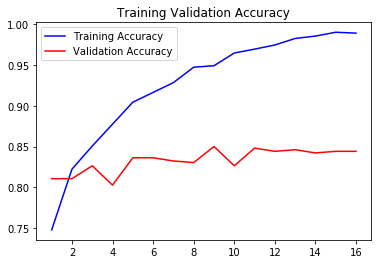

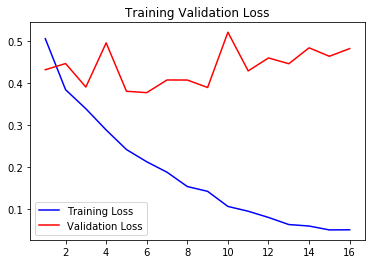

Epoch 1/100
42/43 [============================>.] - ETA: 0s - loss: 0.6413 - accuracy: 0.7541
Epoch 00001: val_loss did not improve from 0.37723
43/43 [==============================] - 44s 1s/step - loss: 0.6337 - accuracy: 0.7573 - val_loss: 0.4606 - val_accuracy: 0.7850
Epoch 2/100
42/43 [============================>.] - ETA: 0s - loss: 0.3628 - accuracy: 0.8341
Epoch 00002: val_loss improved from 0.37723 to 0.33053, saving model to /content/gdrive/My Drive/Refined_Data/saved_model/pc_tf_fine_160_final.h5
43/43 [==============================] - 18s 414ms/step - loss: 0.3604 - accuracy: 0.8358 - val_loss: 0.3305 - val_accuracy: 0.8343
Epoch 3/100
42/43 [============================>.] - ETA: 0s - loss: 0.2913 - accuracy: 0.8746
Epoch 00003: val_loss improved from 0.33053 to 0.29799, saving model to /content/gdrive/My Drive/Refined_Data/saved_model/pc_tf_fine_160_final.h5
43/43 [==============================] - 21s 477ms/step - loss: 0.2888 - accuracy: 0.8765 - val_loss: 0.2980 - 

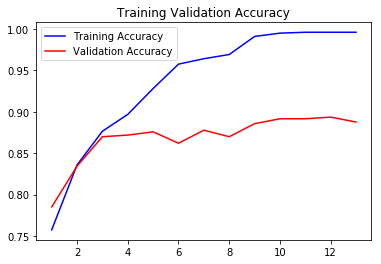

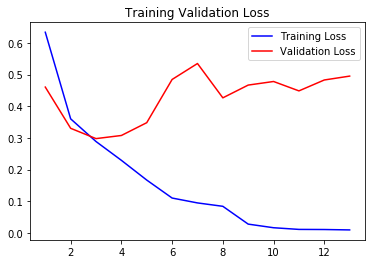

In [19]:
def train_vgg16_model(train_dataset, valid_dataset, model_path, train_steps, valid_steps):
  conv_base = tf.keras.applications.VGG16(weights='imagenet',include_top=False,input_shape=(160, 160, 3));
  conv_base.trainable = False;
  model = tf.keras.Sequential()
  model.add(conv_base)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'));

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy']);

  earlystop = tf.keras.callbacks.EarlyStopping(patience=10);
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.000001);
  modelsave = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, save_best_only=True, verbose=1)

  model.fit_generator(train_dataset, steps_per_epoch=train_steps, epochs=100, validation_steps=valid_steps,
                          validation_data=valid_dataset,callbacks=[earlystop, modelsave, reduce_lr]);
  
  history = model.history.history;

  plotaccuracy(history);
  plotloss(history);
  
  conv_base.trainable = True;
  set_trainable = False
  for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy']);
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0000001);
  
  model.fit_generator(train_dataset, steps_per_epoch=train_steps, epochs=100, validation_steps=valid_steps,
                          validation_data=valid_dataset,callbacks=[earlystop, modelsave, reduce_lr]);
  
  history = model.history.history;

  plotaccuracy(history);
  plotloss(history);
  return model;

model_name = os.path.join(model_loc,'pc_tf_fine_160_final.h5');
model_vgg16 = train_vgg16_model(train_ds,valid_ds,model_name,train_steps,valid_steps);


# Test Data Accuracy and Report

- Once model is trained and saved, we used the model to test the performance of the model on unseen data (test data).

- We first evaludate the test data to have loss and accracy on test data. 

- As we know that data is imbalance we have more images of diseased type than healthy type so accuracy may not seems best representative of model performance. We need a report which gives us precision, recall and F1 score.

- To get a report we first predict the probabilty against each test sample using predict function of the model, and then convert each probability into its respective class/type/target.

- once we have predicted class, we use sklearn classification_report function to generate a report by using true class and predicted class.

- The classification report is a better measurement to test the performance of a model as compare to accuracy. 

In [22]:
print(model_vgg16.evaluate_generator(test_ds,steps=test_steps));

predictions = model_vgg16.predict_generator(test_ds, steps=test_steps,verbose=1);

predicted_classes = [];
for i in predictions:
  if i >= 0.5:
    predicted_classes.append(1)
  else:
    predicted_classes.append(0);
    

report = classification_report(test_labels, predicted_classes, target_names=label_name)
print(report)

conf_matrix = confusion_matrix(y_true=test_labels, y_pred=predicted_classes)
print(conf_matrix)

[0.3871324180851174, 0.9053255]
169/169 [==============================] - 2s 13ms/step
               precision    recall  f1-score   support

diseased_data       0.93      0.88      0.90        86
 healthy_data       0.89      0.93      0.91        83

    micro avg       0.91      0.91      0.91       169
    macro avg       0.91      0.91      0.91       169
 weighted avg       0.91      0.91      0.91       169

[[76 10]
 [ 6 77]]
